# Задание 4 - Перенос обучения (transfer learning) и тонкая настройка (fine-tuning)

Одной из важнейшних техник в тренировке сетей - использовать заранее натренированные веса на более общей задачи в качестве начальной точки, а потом "дотренировать" их на конкретной.

Такой подход и убыстряет обучение, и позволяет тренировать эффективные модели на маленьких наборах данных.

В этом упражнении мы натренируем классификатор, который отличает хотдоги от не хотдогов!  
(более подробно - https://www.youtube.com/watch?v=ACmydtFDTGs)

Это задание требует доступа к GPU, поэтому его можно выполнять либо на компьютере с GPU от NVidia, либо в [Google Colab](https://colab.research.google.com/).

In [1]:
from collections import namedtuple
import itertools
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image
import PIL
# from socket import timeout
# from google.colab import files

# !pip3 install -q torch torchvision
# !pip3 install -q Pillow==4.0.0

Сначала давайте скачаем данные с картинками. Это сделает код в следующей ячейке. Данные будут разделены на две части. На обучающей выборке, которая будет храниться в папке **train_kaggle**, мы будем строить наши модели, а на тестовой выборке **test_kaggle** будем предсказывать класс, к которому относится фотография (хотдог или нет).

### Если вы в Google Colab!

В нем можно запускать ноутбуки с доступом к GPU. Они не очень быстрые, зато бесплатные!
Каждый ноутбук получает свой собственный environment c доступным диском итд.

Через 90 минут отсуствия активности этот environment пропадает со всеми данными.
Поэтому нам придется скачивать данные каждый раз.

In [2]:
# Download train data
# !wget "https://storage.googleapis.com/dlcourse_ai/train.zip"
# !unzip -q "train.zip"

train_folder = "train_kaggle/"
# Count number of files in the train folder, should be 4603
print('Number of files in the train folder', len(os.listdir(train_folder)))

# Download test data
# !wget "https://storage.googleapis.com/dlcourse_ai/test.zip"
# !unzip -q "test.zip"

test_folder = "test_kaggle/"
# Count number of files in the test folder, should be 1150
print('Number of files in the test folder', len(os.listdir(test_folder)))

Number of files in the train folder 4603
Number of files in the test folder 1150


In [3]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0") # Let's make sure GPU is available!

# Имплементируем свой Dataset для загрузки данных

В этом задании мы реализуем свой собственный класс Dataset для загрузки данных. Его цель - загрузить данные с диска и выдать по ним тензор с входом сети, меткой и идентификатором картинки (так будет проще подготовить сабмит для kaggle на тестовых данных).

Вот ссылка, где хорошо объясняется как это делать на примере: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Ваш Dataset должен в качестве количества сэмплов выдать количество файлов в папке и уметь выдавать кортеж из сэмпла, метки по индексу и названия файла.
Если название файла начинается со слов 'frankfurter', 'chili-dog' или 'hotdog' - метка положительная. Иначе отрицательная (ноль).

И не забудьте поддержать возможность трансформации входа (аргумент `transforms`), она нам понадобится!

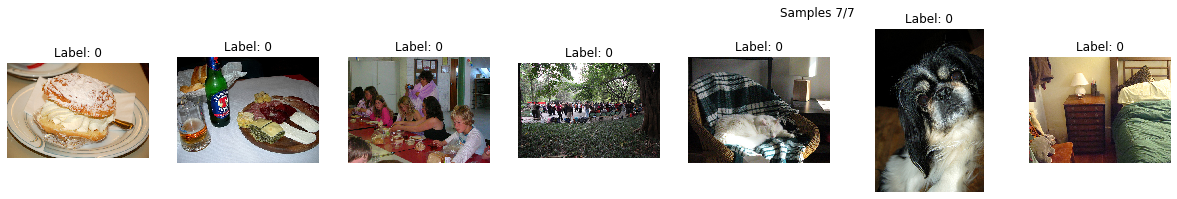

In [4]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        # TODO: Your code here!
        self.folder = folder
        
    def __len__(self):
        return len(os.listdir(self.folder))
    
    def __getitem__(self, index):        
        # TODO Implement getting item by index
        # Hint: os.path.join is helpful!
        imgs = os.listdir(self.folder)
        this_img = imgs[index]
        img_path = os.path.join(self.folder, this_img)
        img = Image.open(img_path)

        if this_img.startswith(('frankfurter','chili-dog','hotdog')):
            y = 1
        else:
            y = 0

        if self.transform:
            img = self.transform(img)
        
        return img, y, this_img

def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   
    
orig_dataset = HotdogOrNotDataset(train_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

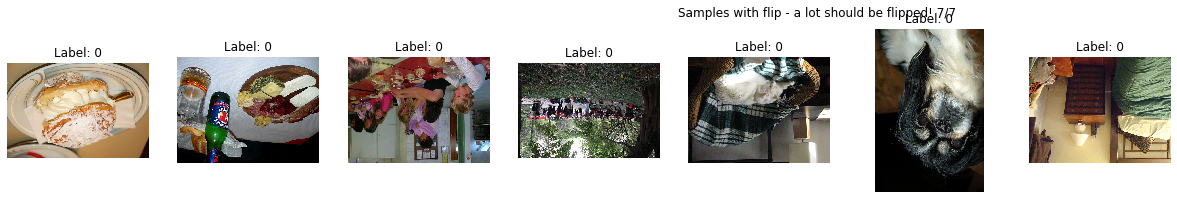

In [5]:
# Let's make sure transforms work!
dataset = HotdogOrNotDataset(train_folder, transform=transforms.RandomVerticalFlip(0.9))

visualize_samples(dataset, indices, "Samples with flip - a lot should be flipped!")

# Создаем Dataset для тренировки

И разделяем его на train и validation.
На train будем обучать модель, на validation проверять ее качество, а соревнование Kaggle In-Class проведем на фотографиях из папки test_kaggle.

In [6]:
# First, lets load the dataset
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [7]:
batch_size = 64

data_size = len(dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)
# Notice that we create test data loader in a different way. We don't have the labels.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Наши обычные функции для тренировки

In [8]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    correct_samples = 0
    total_samples = 0
    for x, y, _ in loader:
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y.shape[0]
    accuracy = float(correct_samples) / total_samples
    return accuracy

# Использование заранее натренированной сети (pretrained network)

Чаще всего в качестве заранее натренированной сети используется сеть, натренированная на данных ImageNet с 1M изображений и 1000 классами.

PyTorch включает такие натренированные сети для различных архитектур (https://pytorch.org/docs/stable/torchvision/models.html)  
Мы будем использовать ResNet18.

Для начала посмотрим, что выдает уже натренированная сеть на наших картинках. То есть, посмотрим к какому из 1000 классов их отнесет сеть.

Запустите модель на 10 случайных картинках из датасета и выведите их вместе с классами с наибольшей вероятностью.  
В коде уже есть код, который формирует соответствие между индексами в выходном векторе и классами ImageNet.

In [9]:
# Thanks to https://discuss.pytorch.org/t/imagenet-classes/4923/2
def load_imagenet_classes():
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    
    # TODO: Process it to return dict of class index to name
    return { int(k): v[-1] for k, v in classes.items()}
    
model = models.resnet18(pretrained=True)

# TODO: Run this model on 10 random images of your dataset and visualize what it predicts

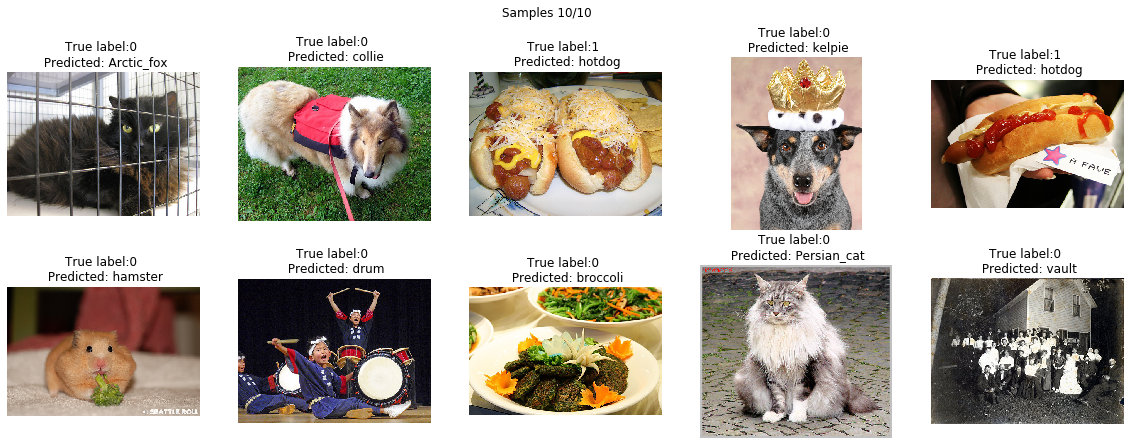

In [10]:
tsf = transforms.Compose([transforms.Resize((224, 224)),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                               std=[0.229, 0.224, 0.225])])
idx_to_class = load_imagenet_classes()

def visualize_actual_predicted(model, transform, dataset, indices, title=None, count=10):
    # visualize random 10 samples
    fig, ax = plt.subplots(2, 5, figsize=(20, 7))
    model.eval()
    ax = ax.ravel()
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        
        prediction = model(transform(x).unsqueeze(0))
        _, index = torch.max(prediction, 1)
        y_pred = idx_to_class[index.item()]
        
        ax[i].set_title(f'True label:{y} \n Predicted: {y_pred}')
        ax[i].imshow(x)
        ax[i].grid(False)
        ax[i].axis('off')
np.random.seed(1)
indices = np.random.choice(np.arange(len(orig_dataset)), 10, replace=False)
visualize_actual_predicted(model, tsf, orig_dataset, indices, "Samples")

# Перенос обучения (transfer learning) - тренировать только последний слой

Существует несколько вариантов переноса обучения, мы попробуем основные.  
Первый вариант - заменить последний слой на новый и тренировать только его, заморозив остальные.

In [11]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Freeze all the layers of this model and add a new output layer
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) # Hotdog or not

model = model.to(device)

parameters = model.fc.parameters()   # Fill the right thing here!

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD( parameters, lr=0.001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 2)

Average loss: 0.367001, Train accuracy: 0.837632, Val accuracy: 0.892391
Average loss: 0.218770, Train accuracy: 0.909585, Val accuracy: 0.918478


# Перенос обучения (transfer learning) - тренировать всю модель

Второй вариант - точно так же заменить последгний слой на новый и обучать всю модель целиком.

In [12]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Add a new output layer and train the whole model
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)
parameters = model.parameters()

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD( parameters, lr=0.001, momentum=0.9)

loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.284859, Train accuracy: 0.879989, Val accuracy: 0.925000
Average loss: 0.134191, Train accuracy: 0.948412, Val accuracy: 0.942391
Average loss: 0.091050, Train accuracy: 0.966875, Val accuracy: 0.951087
Average loss: 0.070451, Train accuracy: 0.976649, Val accuracy: 0.946739
Average loss: 0.048394, Train accuracy: 0.985881, Val accuracy: 0.948913


# Перенос обучения (transfer learning) - разные скорости обучения для разных слоев

И наконец последний вариант, который мы рассмотрим - использовать разные скорости обучения для новых и старых слоев

In [13]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Add a new output layer
# Train new layer with learning speed 0.001 and old layers with 0.0001
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) # Hotdog or not
model = model.to(device)

my_list = ['fc.weight', 'fc.bias']
old_weights = list(filter(lambda kv: kv[0] not in my_list, model.named_parameters()))
new_weights = list(filter(lambda kv: kv[0] in my_list, model.named_parameters()))


old_weights = [i[1] for i in old_weights]
new_weights = [i[1] for i in new_weights]

loss = nn.CrossEntropyLoss()

# Hint - look into what PyTorch optimizers let you configure!
optimizer = optim.SGD([
    {'params': old_weights},
    {'params': new_weights, 'lr': 0.001}], lr=0.0001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.378905, Train accuracy: 0.821884, Val accuracy: 0.900000
Average loss: 0.193879, Train accuracy: 0.929405, Val accuracy: 0.930435
Average loss: 0.174726, Train accuracy: 0.935922, Val accuracy: 0.930435
Average loss: 0.146985, Train accuracy: 0.945696, Val accuracy: 0.939130
Average loss: 0.131040, Train accuracy: 0.951127, Val accuracy: 0.939130


# Визуализируем метрики и ошибки модели

Попробуем посмотреть, где модель ошибается - визуализируем ложные срабатывания (false positives) и ложноотрицательные срабатывания (false negatives).

Для этого мы прогоним модель через все примеры и сравним ее с истинными метками (ground truth).

In [14]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    subsampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=subsampler)
    
    predictions = np.empty(0, dtype = int)
    ground_truth = np.empty(0, dtype = int)

    for x, y, _ in loader:
        x_gpu = x.to(device)
        prediction = model(x_gpu)
        _, indimax = torch.max(prediction, 1)
        predictions = np.concatenate([predictions, indimax.cpu().numpy()])
        ground_truth = np.concatenate([ground_truth, y])
        
    return np.array(predictions), np.array(ground_truth)

predictions, gt = evaluate_model(model, train_dataset, val_indices)

И теперь можно визуализировать false positives и false negatives.

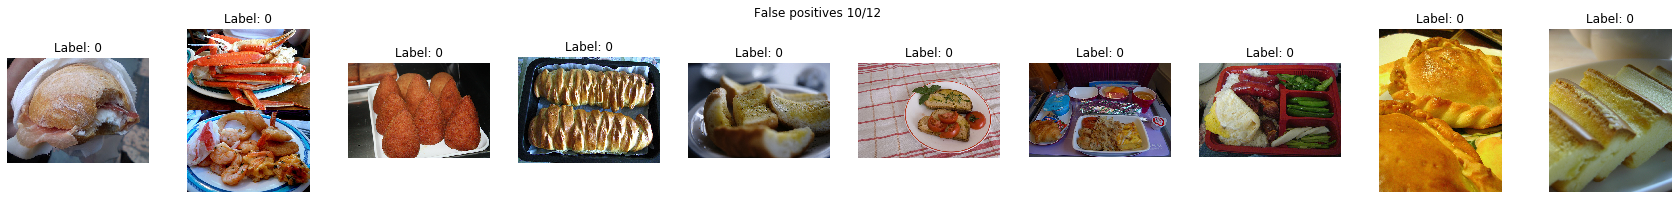

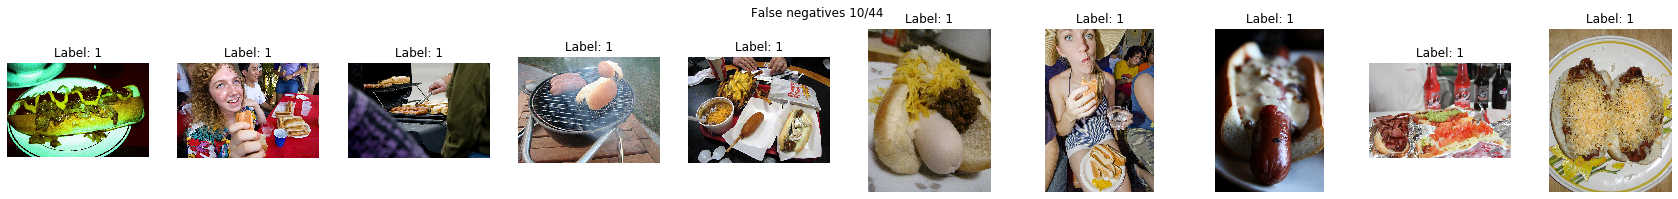

In [15]:
# TODO: Compute indices of the false positives on the validation set.
# Note those have to be indices of the original dataset
false_positive_indices = np.array(val_indices)[(predictions == 1)*(gt == 0)]
visualize_samples(orig_dataset, false_positive_indices, "False positives")
# # TODO: Compute indices of the false negatives on the validation set.
# # Note those have to be indices of the original dataset
false_negatives_indices = np.array(val_indices)[(predictions == 0)*(gt == 1)]
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")

In [16]:
import sklearn.metrics as metrics
def binary_classification_metrics(prediction, ground_truth):
    precision = 0
    recall = 0
    accuracy = 0
    f1 = 0

    # TODO: implement metrics!
    # Some helpful links:
    # https://en.wikipedia.org/wiki/Precision_and_recall
    # https://en.wikipedia.org/wiki/F1_score
    # Implemented below
    predicted_positive = sum(prediction)
    tp = sum(prediction*ground_truth)
    fp = predicted_positive - tp

    precision = tp/predicted_positive
    recall = tp/sum(ground_truth)

    # Check that precision/recall are not zero
    if recall > 0 and precision > 0:
        f1 = 2/(1/recall + 1/precision)
    else:
        warnings.warn('Either precision or recall equal zero. Cannot calculate proper F1-measure')
        f1 = 0
    return precision, recall, f1

precision, recall, f1 = binary_classification_metrics(predictions, gt)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

F1: 0.898, P: 0.953, R: 0.848


# Что будет в конце вы уже поняли

Натренируйте лучшую модель на основе `resnet18`, меняя только процесс тренировки.
Выбирайте лучшую модель по F1 score.

Как всегда, не забываем:
- побольше агментаций!
- перебор гиперпараметров
- различные оптимизаторы
- какие слои тюнить
- learning rate annealing
- на какой эпохе останавливаться

Наша цель - довести F1 score на validation set до значения, большего **0.93**.

## First let's do a simple setup: augmentations, training function and datasets

In [17]:
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=.20, saturation=.20),
#     transforms.RandomVerticalFlip(0.9),
    transforms.RandomHorizontalFlip(0.5),
#     transforms.RandomRotation(3, resample=PIL.Image.BILINEAR),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])                             
])

# TODO create new instances of loaders with the augmentations you chose

In [18]:
# First, lets load the dataset
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
train_aug_dataset = HotdogOrNotDataset(train_folder, transform=tfs)

test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [19]:
batch_size = 64

data_size = len(dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_aug_loader = torch.utils.data.DataLoader(train_aug_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)
# Notice that we create test data loader in a different way. We don't have the labels.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [20]:
def evaluate_model_while_train(model, val_loader):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    predictions = np.empty(0, dtype = int)
    ground_truth = np.empty(0, dtype = int)

    for x, y, _ in val_loader:
        x_gpu = x.to(device)
        prediction = model(x_gpu)
        _, indimax = torch.max(prediction, 1)
        predictions = np.concatenate([predictions, indimax.cpu().numpy()])
        ground_truth = np.concatenate([ground_truth, y])
        
    return np.array(predictions), np.array(ground_truth)

In [21]:
def train_model_with_sched(model,
                           train_loader,
                           val_loader,
                           loss,
                           optimizer,
                           num_epochs,
                           scheduler=None,
                           early_stop = 0.93):    
    loss_history = []
    train_history = []
    val_history = []
    val_f1_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0

        for i_step, (x, y, _) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu) 
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))

        predictions, gt = evaluate_model_while_train(model, val_loader)
        precision, recall, f1 = binary_classification_metrics(predictions, gt)
        
        val_f1_history.append(f1)
        print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

        if scheduler:
            scheduler.step()

        if f1 > early_stop:
            print('===========================')
            print('Look here! I stopped early!')
            print('===========================')
            break
    return loss_history, train_history, val_history, val_f1_history

In [26]:
Hyperparams = namedtuple("Hyperparams", ['optimizer', 'learning_rate', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_f1'])

epoch_num = 15

learning_rates = [0.001, 0.0001, 0.004]
reg = [1e-4, 1e-5]

run_record = {} 

# TODO: Your code here!
print('Try SGD optimizer with momentum')
for lr, reg in itertools.product(learning_rates, reg):
    print('Current set of parameters is: learning rate = {0}, reg = {1}'.format(lr, reg))
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay = reg)

    loss_history, train_history, val_history, val_f1_history = train_model_with_sched(
        model,
        train_aug_loader,
        val_loader,
        loss,
        optimizer,
        epoch_num,
        scheduler = None,
        early_stop = 0.930)

    running_res = RunResult(model, train_history, val_history, val_f1_history[-1])
    params = Hyperparams('SGD', lr, reg)
    run_record[params] = running_res

print('Try Adam optimizer')
learning_rates = [0.001, 0.003, 0.004]
reg = [1e-4, 1e-5]

# for lr, reg in itertools.product(learning_rates, reg):
#     print('Current set of parameters is: learning rate = {0}, reg = {1}'.format(lr, reg))
#     model = models.resnet18(pretrained=True)
#     num_ftrs = model.fc.in_features
#     model.fc = nn.Linear(num_ftrs, 2)
#     model.to(device)
    
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

#     loss_history, train_history, val_history, val_f1_history = train_model_with_sched(
#         model,
#         train_aug_loader,
#         val_loader,
#         loss,
#         optimizer,
#         epoch_num,
#         scheduler = None,
#         early_stop = 0.930)
    
#     running_res = RunResult(model, train_history, val_history, val_f1_history[-1])
#     params = Hyperparams('Adam', lr, reg)
#     run_record[params] = running_res

Try SGD optimizer with momentum
Current set of parameters is: learning rate = 0.001, reg = 0.0001
Average loss: 0.334968, Train accuracy: 0.844149, Val accuracy: 0.935870
F1: 0.895, P: 0.923, R: 0.869
Average loss: 0.191839, Train accuracy: 0.927233, Val accuracy: 0.940217
F1: 0.906, P: 0.898, R: 0.914
Average loss: 0.152761, Train accuracy: 0.941352, Val accuracy: 0.942391
F1: 0.906, P: 0.931, R: 0.883
Average loss: 0.124129, Train accuracy: 0.953842, Val accuracy: 0.938043
F1: 0.897, P: 0.940, R: 0.859
Average loss: 0.104816, Train accuracy: 0.960901, Val accuracy: 0.945652
F1: 0.912, P: 0.935, R: 0.890
Average loss: 0.092245, Train accuracy: 0.968775, Val accuracy: 0.946739
F1: 0.917, P: 0.900, R: 0.934
Average loss: 0.078497, Train accuracy: 0.972848, Val accuracy: 0.950000
F1: 0.922, P: 0.907, R: 0.938
Average loss: 0.067437, Train accuracy: 0.978279, Val accuracy: 0.943478
F1: 0.907, P: 0.941, R: 0.876
Average loss: 0.056451, Train accuracy: 0.982351, Val accuracy: 0.952174
F1: 0

F1: 0.887, P: 0.960, R: 0.824
Average loss: 0.094052, Train accuracy: 0.963888, Val accuracy: 0.942391
F1: 0.911, P: 0.886, R: 0.938
Average loss: 0.058187, Train accuracy: 0.980451, Val accuracy: 0.945652
F1: 0.915, P: 0.905, R: 0.924
Average loss: 0.037222, Train accuracy: 0.987239, Val accuracy: 0.939130
F1: 0.908, P: 0.866, R: 0.955
Average loss: 0.030219, Train accuracy: 0.989411, Val accuracy: 0.950000
F1: 0.919, P: 0.936, R: 0.903
Average loss: 0.033863, Train accuracy: 0.988053, Val accuracy: 0.944565
F1: 0.912, P: 0.916, R: 0.907
Average loss: 0.020021, Train accuracy: 0.992941, Val accuracy: 0.953261
F1: 0.924, P: 0.949, R: 0.900
Average loss: 0.011174, Train accuracy: 0.995656, Val accuracy: 0.945652
F1: 0.915, P: 0.900, R: 0.931
Average loss: 0.014374, Train accuracy: 0.995384, Val accuracy: 0.951087
F1: 0.922, P: 0.924, R: 0.921
Average loss: 0.009560, Train accuracy: 0.997013, Val accuracy: 0.948913
F1: 0.919, P: 0.920, R: 0.917
Average loss: 0.010905, Train accuracy: 0.9

Average loss: 0.536859, Train accuracy: 0.720880, Val accuracy: 0.679348
F1: 0.604, P: 0.495, R: 0.776
Average loss: 0.543992, Train accuracy: 0.710291, Val accuracy: 0.710870
F1: 0.523, P: 0.545, R: 0.503
Average loss: 0.523516, Train accuracy: 0.728482, Val accuracy: 0.692391
F1: 0.612, P: 0.508, R: 0.769
Average loss: 0.526232, Train accuracy: 0.737171, Val accuracy: 0.701087
F1: 0.631, P: 0.516, R: 0.810
Average loss: 0.506926, Train accuracy: 0.744230, Val accuracy: 0.596739
F1: 0.585, P: 0.433, R: 0.900
Average loss: 0.497506, Train accuracy: 0.756992, Val accuracy: 0.746739
F1: 0.490, P: 0.671, R: 0.386
Average loss: 0.485419, Train accuracy: 0.764323, Val accuracy: 0.733696
F1: 0.415, P: 0.674, R: 0.300
Average loss: 0.481582, Train accuracy: 0.761879, Val accuracy: 0.763043
F1: 0.660, P: 0.602, R: 0.731
Average loss: 0.455725, Train accuracy: 0.782786, Val accuracy: 0.748913
F1: 0.531, P: 0.645, R: 0.452
Average loss: 0.455394, Train accuracy: 0.786044, Val accuracy: 0.740217


Вообще говоря, я несколько удивлен. Я попробовал несколько вариантов, и вот что у меня **не** получилось:
    - Самое большое удивление: Adam на этой задаче сработал не очень хорошо. `SGD` с моментом и поправкой Нестерова сработали лучше.
    - Пробовал `scheduler` - снижение `learning rate` на разных эпохах. Это помогало `Adam`, но это совсем не помогало `SGD`, а потому я в итоге убрал его из экспериментов.
    - Тренировка разных слоев с разной скоростью только ухудшала метрику качества. В итоге я стал тренировать всю сеть целиком.

In [33]:
# TODO: Train your best model!
best_val_f1 = None
best_hyperparams = None
best_model = None


for hyperparams, run_result in run_record.items():
    if best_val_f1 is None or best_val_f1 < run_result.final_val_f1:
        best_val_f1 = run_result.final_val_f1
        best_hyperparams = hyperparams
        best_model = run_result.model
        best_model_train_history = run_result.train_history
        best_model_val_history = run_result.val_history
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_f1, best_hyperparams))

Best validation accuracy: 0.93, best hyperparams: Hyperparams(optimizer='SGD', learning_rate=0.004, reg=0.0001)


In [28]:
# Let's check how it performs on validation set!
predictions, ground_truth = evaluate_model(best_model, train_dataset, val_indices)
precision, recall, f1 = binary_classification_metrics(predictions, ground_truth)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

# TODO: Visualize training curve for the best model

F1: 0.932, P: 0.947, R: 0.917


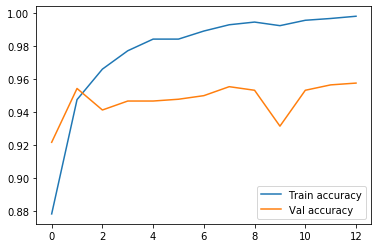

In [37]:
plt.plot(best_model_train_history, label='Train accuracy')
plt.plot(best_model_val_history, label='Val accuracy')
plt.legend()

## Визуализируйте ошибки лучшей модели

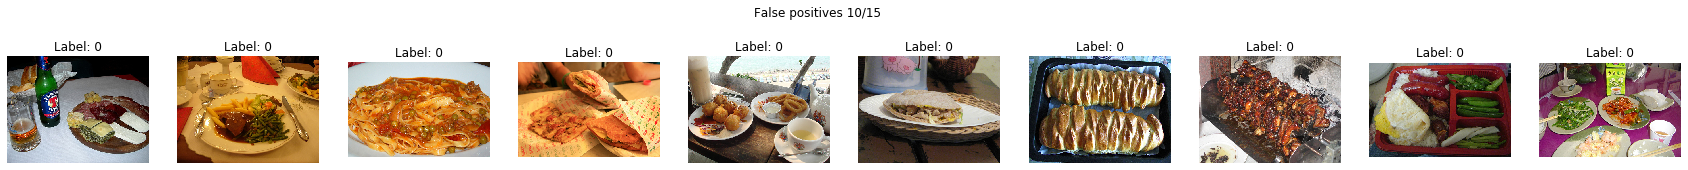

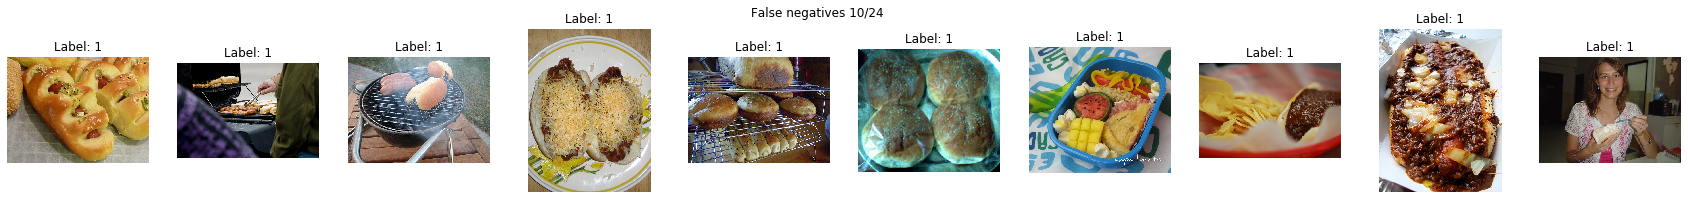

In [35]:
# TODO Visualize false positives and false negatives of the best model on the validation set
false_positive_indices = np.array(val_indices)[(predictions == 1)*(gt == 0)]
visualize_samples(orig_dataset, false_positive_indices, "False positives")
# # TODO: Compute indices of the false negatives on the validation set.
# # Note those have to be indices of the original dataset
false_negatives_indices = np.array(val_indices)[(predictions == 0)*(gt == 1)]
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")

# Необязательное задание с большой звездочкой

Поучавствуйте в Kaggle In-Class Hot Dog Recognition Challenge!  
Это соревнование сделано специально для курса и в нем учавствуют только те, кто проходит курс.

В нем участники соревнуются в качестве натренированных моделей, загружая на сайт предсказания своих моделей на тестовой выборке. Разметка тестовой выборке участникам недоступна.
Более подробно о правилах соревнования ниже.

Те, кто проходят курс лично, за высокое место в соревновании получат дополнительные баллы.

Здесь уже можно использовать и другие базовые архитектуры кроме `resnet18`, и ансамбли, и другие трюки тренировки моделей.

Вот ссылка на соревнование:
https://www.kaggle.com/c/hotdogornot

In [ ]:
image_id = []
predictions = []
model.eval()
for x,_,id_img in test_loader:
    # TODO : Напишите код для предсказания меток (1 = есть хотдог, 0 = хотдога нет)
    # Код должен возвратить список из id картинки и метку predictions
    # image id - это название файла картинки, например '10000.jpg'
    pass

In [ ]:
# Так можно создать csv файл, чтобы затем загрузить его на kaggle
# Ожидаемый формат csv-файла:
# image_id,label
# 10000.jpg,1
# 10001.jpg,1
# 10002.jpg,0
# 10003.jpg,1
# 10004.jpg,0

with open('subm.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerow(['image_id', 'label'])
    writer.writerows(zip(image_id,predictions))

In [ ]:
# А так можно скачать файл с Google Colab
files.download('subm.csv') 

### Небольшое введение в Kaggle для тех, кто не слышал об этой платформе раньше

В основе своей Kaggle - это платформа для проведения соревнований по машинному обучению. Появилась она в 2010 и, пожалуй, стала самой популярной и известной из всех существующих площадок по машинному обучению. Надо сказать, что Kaggle - это не только соревнования, но и сообщество людей, увлеченных машинным обучением. А судя по Википедии, в 2017 году отметка зарегистрированных пользователей перевалила за миллион. Есть там и обучающие материалы, возможность задавать вопросы, делиться кодом и идеями - просто мечта. 

### Как проходят соревнования? 
Обычно участники скачивают данные для обучения моделей (train data), чтобы затем делать предсказания на тестовых данных (test data). Обучающая выборка содержит как сами данные, так и правильные метки (значения зависимой переменной), чтобы можно было обучить модель. Но тестовые данные ответа не содержат - и нашей целью является предсказание меток по имеющимся данным. Файл с ответами для каждого наблюдения из тестовой выборки загружается на Kaggle и оценивается в соответствии с выбранной метрикой соревнования, а результат является публичным и показывается в общей таблице (ее называют еще лидербордом - leaderboard) - чтобы появилось желание посоревноваться и создать еще более сильную модель. В "настоящих" соревнованиях, которые проходят на Kaggle, есть и денежное вознаграждение для тех участников, кто занимает первые места на лидерборде. Например, в [этом](https://www.kaggle.com/c/zillow-prize-1#description) соревновании, человек, занявший первое место, получил около 1 000 000 долларов. 

Тестовые данные делятся случайным образом в некоторой пропорции. И пока соревнование идет, на лидерборде показываются очки и рейтинг участников только по одной части (Public Leaderboard). А вот когда соревнование заканчивается, то рейтинг участников составляется по второй части тестовых данных (Private Leaderboard). И часто можно видеть, как люди занимавшие первые места на публичной части тестовых данных, оказываются далеко не первыми на закрытой части тестовых данных. Зачем это сделано? Есть несколько причин, но, пожалуй, самой фундаментальной является идея недообучения-переобучения. Всегда возможно, что наша модель настроилась на конкретную выборку, но как она поведет себя на тех данных, которые еще не видела? Разбиение тестовых данных на публичную и скрытую части сделано для того, чтобы отобрать модели, которые имеют большую обобщающую способность. Одним из лозунгов участников соревнований стал "Доверяйте своей локальной кросс-валидации" (Trust your CV!). Есть очень большой соблазн оценивать свою модель по публичной части лидерборда, но лучшей стратегией будет выбирать ту модель, которая дает лучшую метрику на кросс-валидации на обучающей выборке. 

В нашем соревновании публичная часть лидерборда составляет 30%, а скрытая 70%. Вы можете делать до двух попыток в день, а оцениваться попытки будут по F1-мере. Удачи и доверяйте своей локальной валидации! В конце соревнования у вас будет возможность выбрать 2 из всех совершенных попыток - лучшая из этих двух и будет засчитана вам на скрытой части тестовых данных.